# Using Existing Models

In [1]:
from PIL import Image

import torch
from torchvision import models
from torchvision import transforms

## Image Recognition

In [2]:
resnet = models.resnet101(pretrained=True)

In [3]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

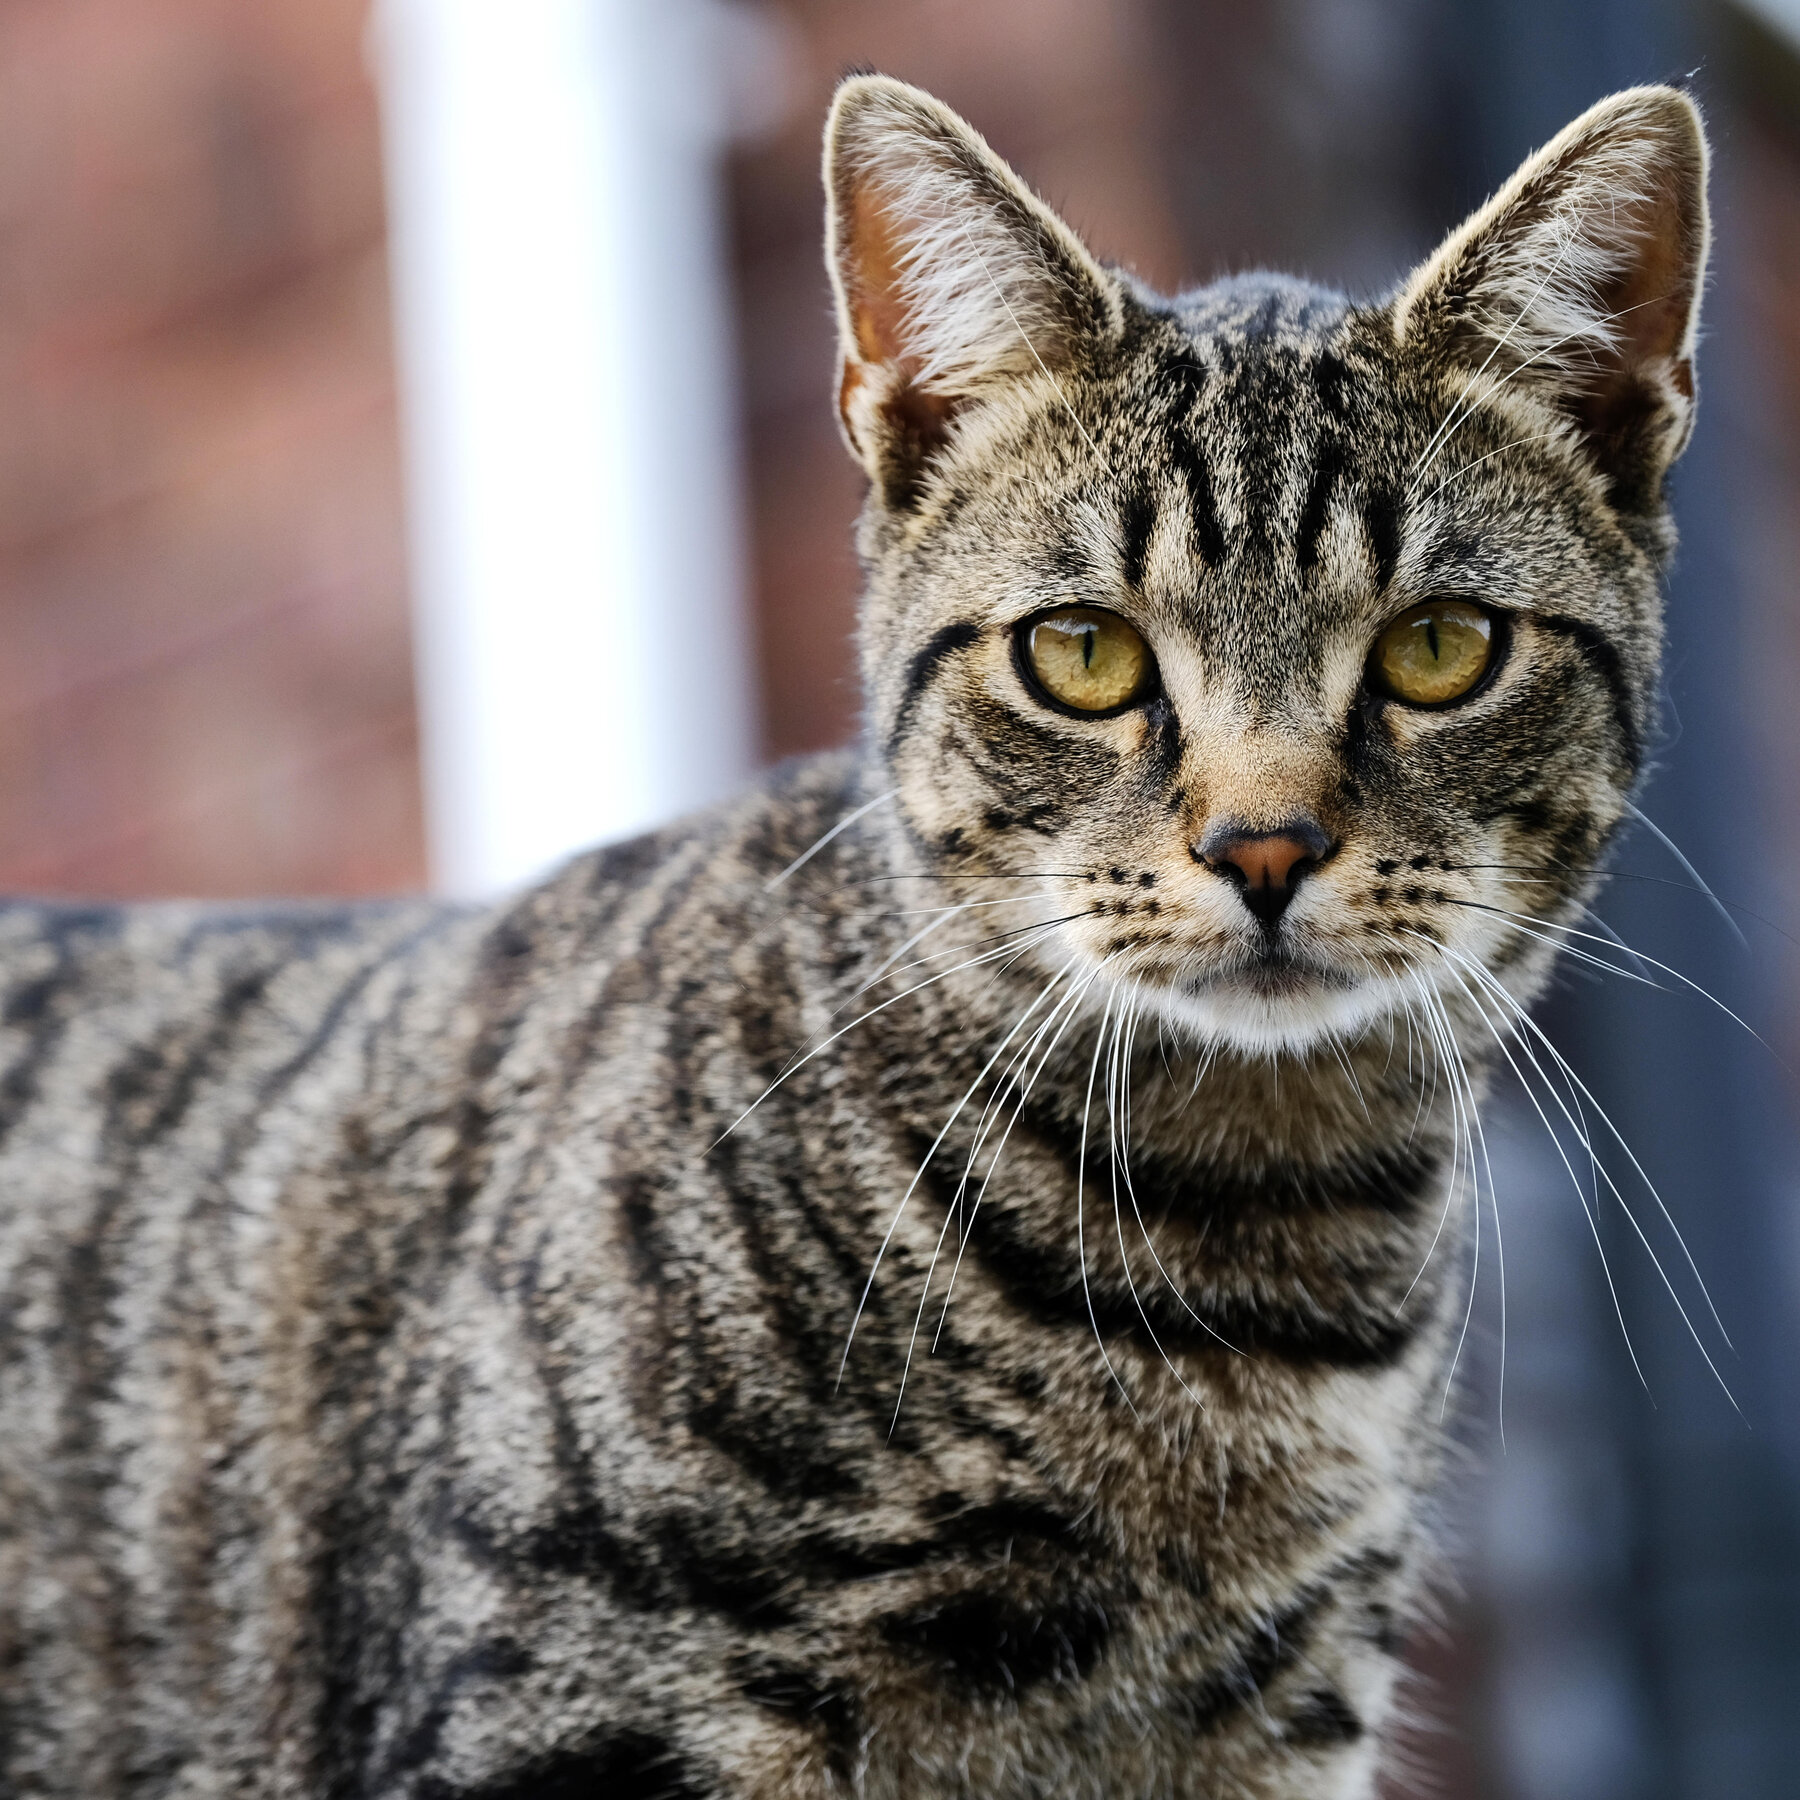

In [5]:
img = Image.open('../data/cat.jpg')
img

In [6]:
img_t = preprocess(img)

In [7]:
batch_t = torch.unsqueeze(img_t, 0)

In [8]:
resnet.eval()
out = resnet(batch_t)
out

c:\users\rebs\documents\dev\data-science-env\env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-2.9310e+00, -6.5971e-01, -1.8822e+00, -2.0629e+00, -2.2336e+00,
         -3.2204e+00, -4.3481e+00, -1.1714e+00, -2.1755e-01, -1.9298e+00,
          6.8434e-01, -1.9379e+00,  6.6021e-01, -1.0430e+00, -1.9468e+00,
          2.0364e+00, -2.5281e+00, -1.9845e+00, -6.4373e-01, -3.3846e+00,
          2.0941e-01, -6.7857e-01,  9.2296e-02, -1.3122e+00,  5.3743e+00,
         -1.2039e+00, -3.9647e-01, -4.0287e-01, -1.3576e+00, -2.8047e+00,
         -6.4816e-01, -1.1464e+00, -2.9585e+00, -4.4595e+00, -2.8280e+00,
         -1.1362e+00,  4.0909e-01,  3.9106e-01,  1.0852e+00,  1.7221e+00,
         -6.1138e-01,  2.7042e+00, -7.8396e-01,  1.5728e+00,  2.5061e+00,
         -1.7679e+00,  1.6870e+00, -4.6643e-01,  1.2190e+00, -1.0175e+00,
         -9.7484e-01,  9.2808e-01, -2.0860e-01, -5.4889e-01, -1.1693e+00,
         -1.8542e+00, -2.6202e+00, -1.8114e+00, -1.4052e+00,  6.0937e-01,
         -2.5778e-01, -2.3879e+00, -5.1570e-01, -2.5072e+00, -1.1672e+00,
         -2.7570e+00,  8.0911e-01,  2.

In [9]:
with open('../data/image_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

In [10]:
_, index = torch.max(out, 1)
index

tensor([282])

In [11]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
labels[index[0]], percentage[index[0]].item()

('tiger cat', 79.6674575805664)

In [12]:
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('tiger cat', 79.6674575805664),
 ('tabby, tabby cat', 19.672607421875),
 ('Egyptian cat', 0.5914084315299988),
 ('tiger, Panthera tigris', 0.023916570469737053),
 ('lynx, catamount', 0.007003645412623882)]

## Image Generation

In [14]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv_block = self.build_conv_block(dim)
    
    def build_conv_block(self, dim):
        conv_block = []
        conv_block += [torch.nn.ReflectionPad2d(1)]
        conv_block += [torch.nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       torch.nn.InstanceNorm2d(dim),
                       torch.nn.ReLU(True)]
        conv_block += [torch.nn.ReflectionPad2d(1)]
        conv_block += [torch.nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       torch.nn.InstanceNorm2d(dim)]
        return torch.nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [22]:
class ResNetGenerator(torch.nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9):
        assert(n_blocks >= 0)
        super().__init__()
        
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        
        model = [torch.nn.ReflectionPad2d(3),
                 torch.nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 torch.nn.InstanceNorm2d(ngf),
                 torch.nn.ReLU(True)]
        
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [torch.nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=True),
                      torch.nn.InstanceNorm2d(ngf * mult * 2),
                      torch.nn.ReLU(True)]
        
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]
        
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [torch.nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                               kernel_size=3, stride=2,
                                               padding=1, output_padding=1, bias=True),
                      torch.nn.InstanceNorm2d(int(ngf * mult / 2)),
                      torch.nn.ReLU(True)]
        
        model += [torch.nn.ReflectionPad2d(3)]
        model += [torch.nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [torch.nn.Tanh()]
        
        self.model = torch.nn.Sequential(*model)
    
    def forward(self, input):
        return self.model(input)

In [23]:
gan = ResNetGenerator()

In [25]:
weight_path = '../data/horse2zebra_0.4.0.pth'
weights = torch.load(weight_path)
gan.load_state_dict(weights)

<All keys matched successfully>

In [26]:
gan.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [27]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

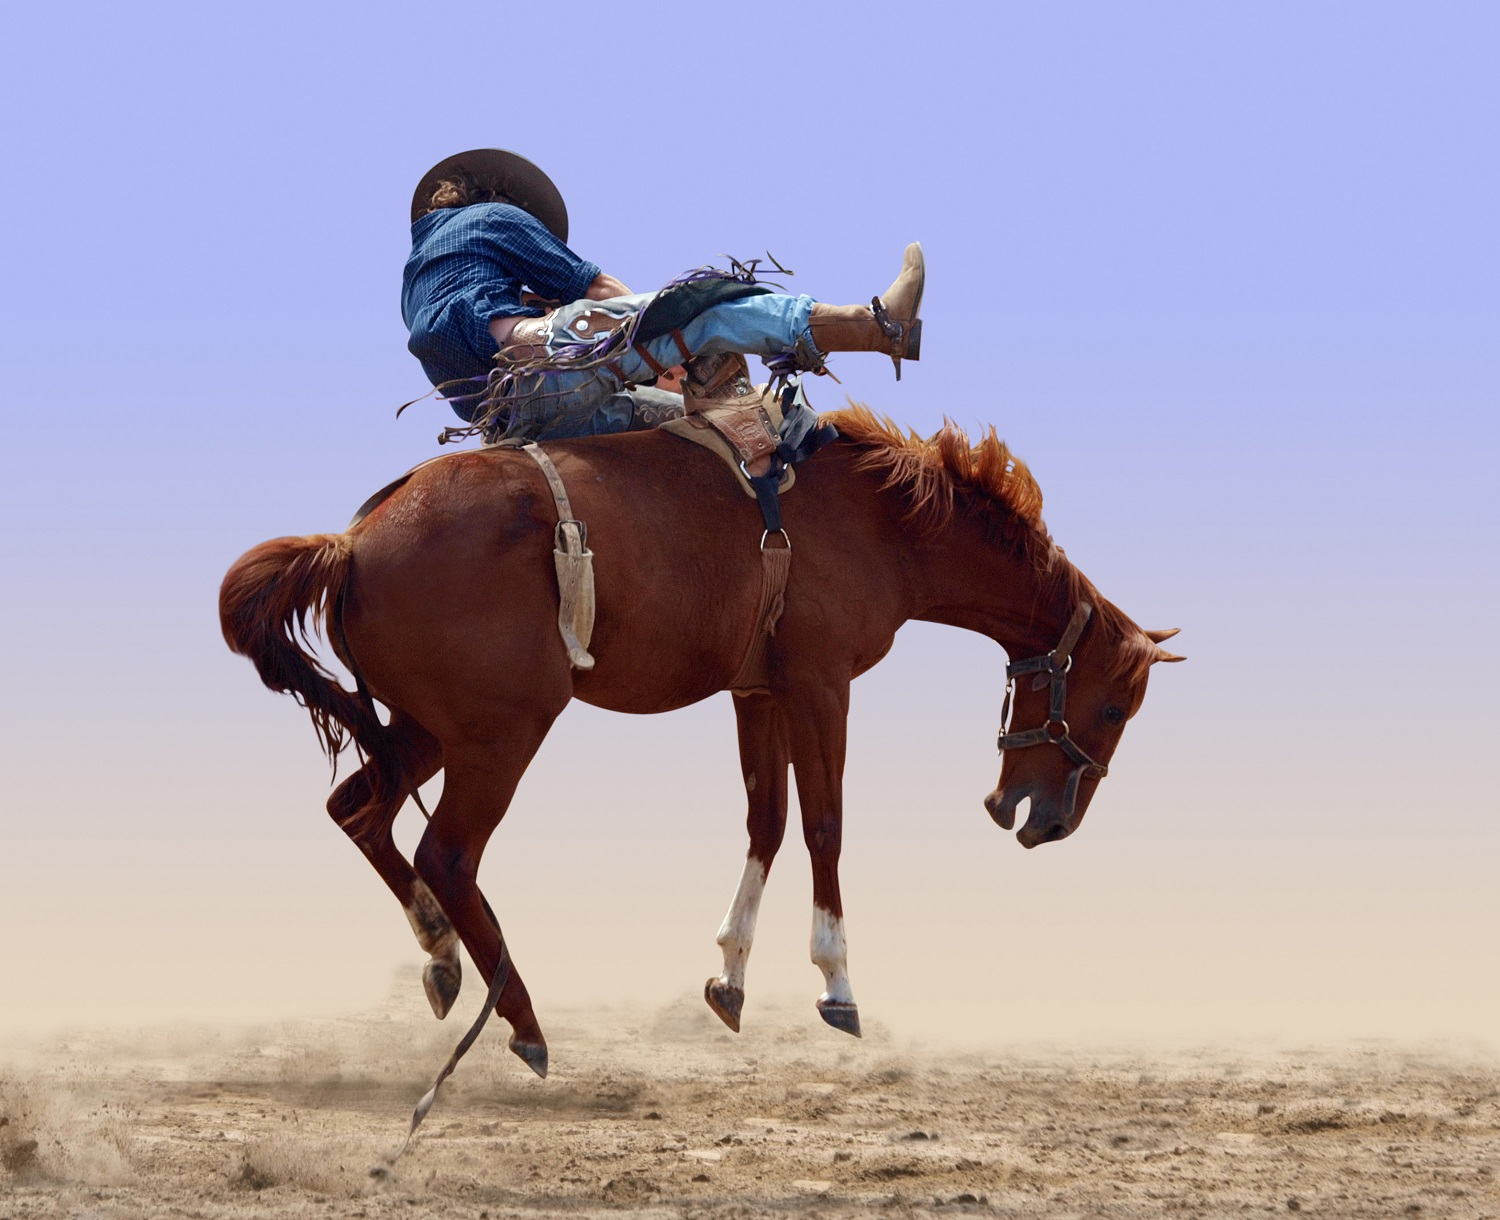

In [28]:
img = Image.open('../data/horse.jpg')
img

In [29]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [30]:
out = gan(batch_t)

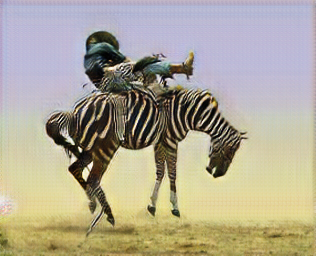

In [32]:
out_t = (out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img